* This notebook targets at 

1) the transition from near- to far-field under three wind event conditions.
2) testing if Rmix is reasonable in defining near and far fiel.
3) Compare the near and far field defined by Rmix with that by Froude number.

In [33]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools)
import matplotlib.gridspec as gridspec
import datetime, os
from glob import glob
from nowcast import figures
import matplotlib.pyplot as plt
import StraTimeSeries as sts
import R_mixStuff as RS
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 
e3t = mesh.variables['e3t'][0,:,380:510,240:397]

In [3]:
river_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc','r')
river_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc','r')
river_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc','r')
nof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc','r')
nof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc','r')
nof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc','r')
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc','r')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc','r')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc','r')
notide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc','r')
notide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_U.nc','r')
notide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_V.nc','r')
nowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc','r')
nowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc','r')
nowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc','r')

* transect

-123.293


(48.95, 49.3)

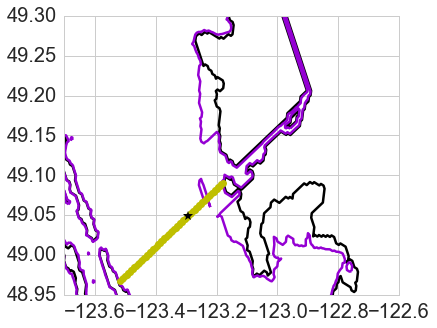

In [4]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
lon = all_T.variables['nav_lon']
lat = all_T.variables['nav_lat']
ax.plot(lon[36,4:70],lat[36,4:70],'yo') ## transect
ax.plot(lon[36,47],lat[36,47],'k*',markersize = 10) ## station
print(lon[36,47])
ax.set_xlim([-123.7,-122.6])
ax.set_ylim([48.95,49.3])

* determine plume salinity, with $S_{offset} = 4.8 - 0.14\times{S_{ref}}$, the threshold works.

In [5]:
def determine_plume_method2(tst,ted,dep_ind,err):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain"""
    fig, axs = plt.subplots(1,2,figsize= (16,5))
    S = all_T.variables['vosaline']
    S_aveN = np.nanmean(S[tst:ted,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    S_aveT =np.nanmean(S[tst:ted,:,36,4:70],axis = 0) ## temporal average of the transect
    jinds = np.arange(4,70)
    iinds = np.arange(36,37)
    ax = axs[0] ## plot salinity along transect
    ax.plot(jinds,S_aveT[dep_ind,:])
    ax.set_ylim([0,30])
    S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average
    S_thre = 1.14*S_ref-4.8
    ax.plot([0,70],[S_thre,S_thre],'g--')
    ax.set_xlabel('Index to west coast')
    ax.set_ylabel('Practical Salinity')
    ax = axs[1] ## salinity contour in the whole subdomain
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    mesh = ax.contourf(lon[:],lat[:],S_aveW[:],cmap = 'jet')
    CS = ax.contour(mesh, colors = 'k',
                  hold='on',linewidths=(2,))
    cbar=fig.colorbar(mesh,ax =ax)
    cbar.add_lines(CS)
    ax.plot(lon[36,4:70],lat[36,4:70],'g.') ## transect
    for i in np.arange(S_aveT.shape[1]):
        if abs(S_aveT[dep_ind,i] -S_thre)<= err:
            print('i,lon,real salinity',i,lon[36,i], S_aveT[dep_ind,i])
            ax.plot(lon[36,i],lat[36,i],'m*',markersize = 10)
    print('S_ref',S_ref)
    print('S_thre',S_thre)
    
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.9,49.5])

S_ref 26.6485
S_thre 25.5792752838


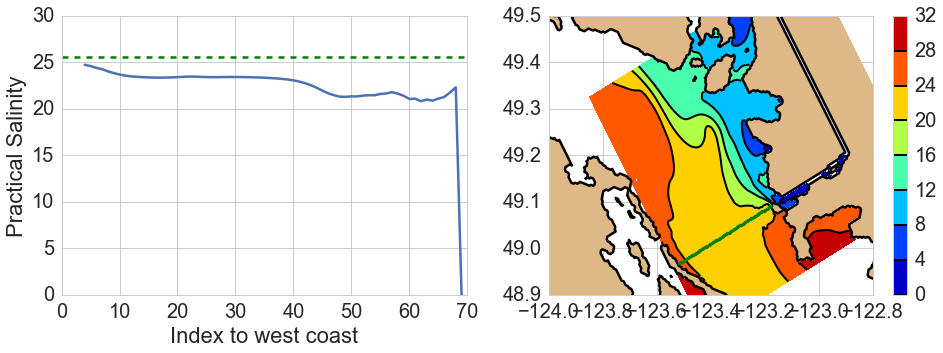

In [9]:
## weak wind + neap tides:
determine_plume_method2(48,143,0,0.2)

i,lon,real salinity 52 -123.267 26.8772
S_ref 27.7213
S_thre 26.8022712708


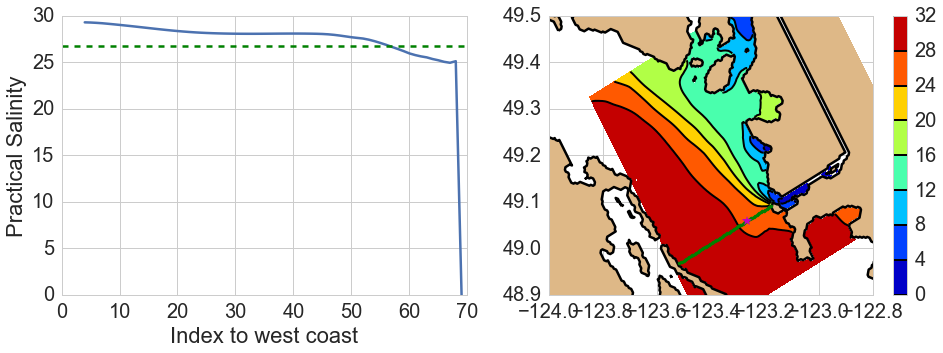

In [10]:
## moderate wind + neap tides:
determine_plume_method2(408,479,0,0.1)

i,lon,real salinity 45 -123.303 28.0463
i,lon,real salinity 46 -123.298 27.9612
S_ref 28.811
S_thre 28.0444909286


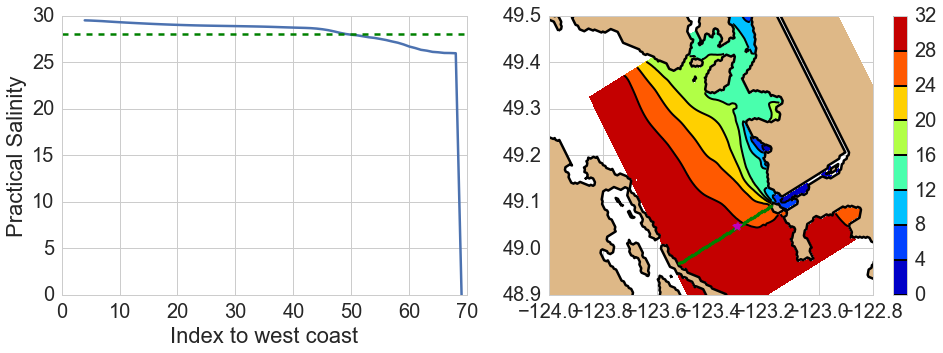

In [11]:
## strong wind + neap tides:
determine_plume_method2(480,551,0,0.1)

* Use Rmix to define near and far field on the transect

In [12]:
def threshold_near_far(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,np_mask,dep_ind):
    """This function is made to select the 
    transition from near to far field in the plume by
    criteria of Rmix(river+wind)/Rmix(all) >=0.9 and 
    Rmix(river+tide)/Rmix(all) <=0.7"""
    far_rmix_wind = [];
    far_rmix_tide = [];
    far_lon = []; iss =[];
    f, rmix = RS.plot_Rmix_together(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,np_mask,dep_ind)
    fig, ax = plt.subplots(1,1,figsize = (14,3))
    for i in np.arange(4,70):
        if (rmix['river+winds'][36,i]/rmix['all'][36,i] >= 0.9) and \
        (rmix['river+tides'][36,i]/rmix['all'][36,i] <= 0.7):
            ax.plot(lon[36,i],rmix['river+winds'][36,i],'g*',markersize = 10)
            ax.plot(lon[36,i],rmix['all'][36,i],'y*',markersize = 10)
            ax.plot(lon[36,i],rmix['river+tides'][36,i],'b*',markersize = 10)
            far_rmix_wind.append(rmix['river+winds'][36,i])
            far_rmix_tide.append(rmix['river+tides'][36,i])
            far_lon.append(lon[36,i])
            iss.append(i)
    ax.set_xlim([-123.55,-123.15])
    return far_rmix_wind,far_rmix_tide,far_lon,iss

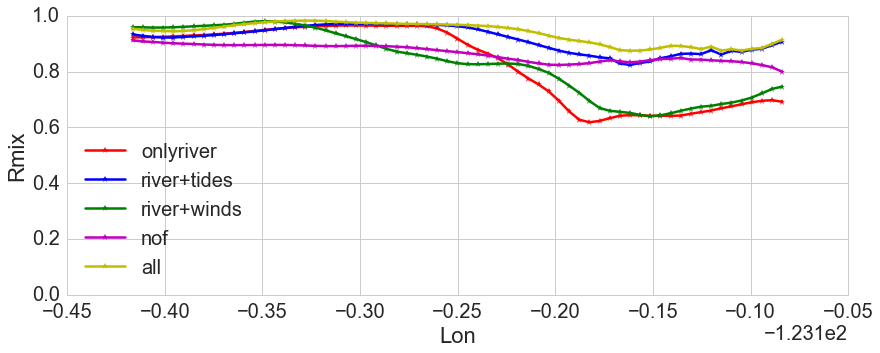

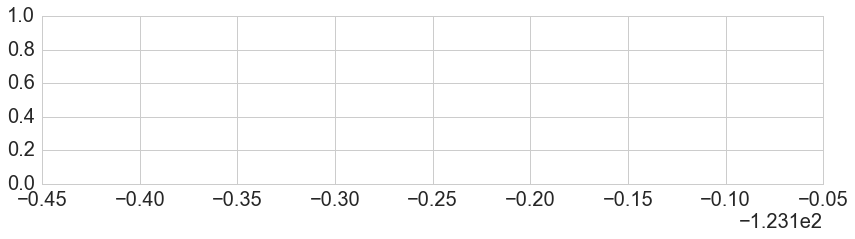

In [23]:
## weak winds +neap tides:
far_rmix_wind,far_rmix_tide,far_lon,iss = threshold_near_far(river_T,nowind_T,notide_T,nof_T,all_T,48,143,np_mask,4)

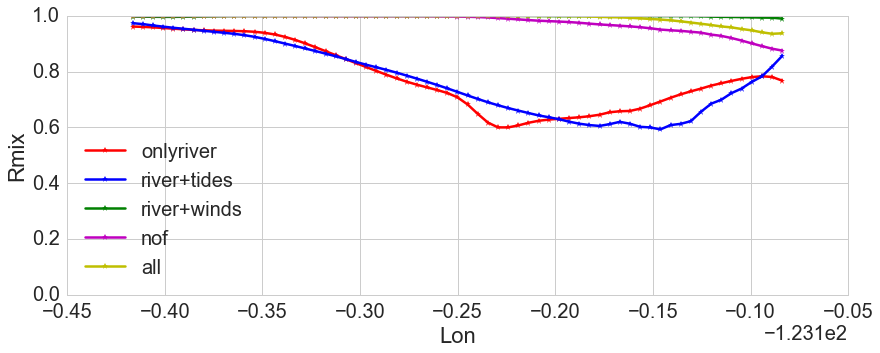

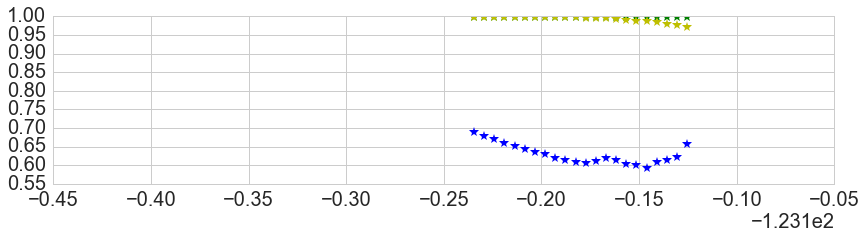

In [24]:
## moderate winds +neap tides:
far_rmix_wind,far_rmix_tide,far_lon,iss = threshold_near_far(river_T,nowind_T,notide_T,nof_T,all_T,408,479,np_mask,4)

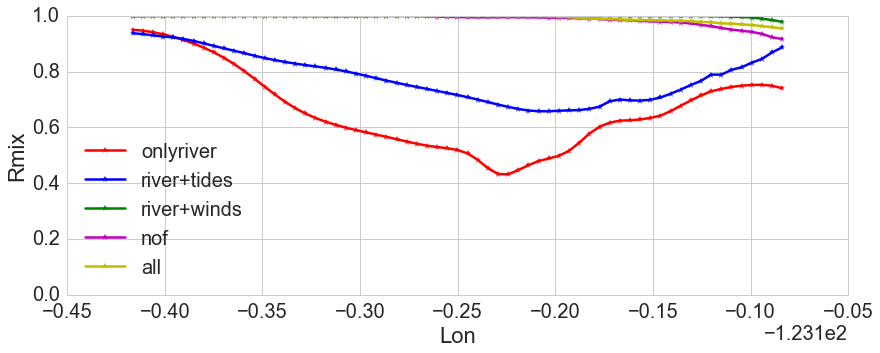

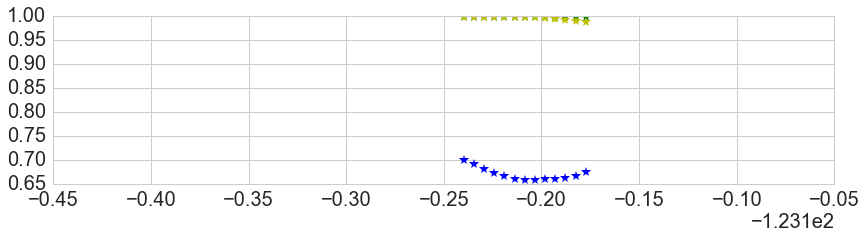

In [25]:
## strong winds+ neap tides:
far_rmix_wind,far_rmix_tide,far_lon,iss = threshold_near_far(river_T,nowind_T,notide_T,nof_T,all_T,480,551,np_mask,4)

In [6]:
def get_Rmix(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,dep_ind):
    """"""
    rmix = {};
    for grid_T,st,in zip([gridT1,gridT2,gridT3,gridT4,gridT5],['onlyriver','river+tides',\
                        'river+winds','nof','all']):
        S = grid_T.variables['vosaline']
        lon = grid_T.variables['nav_lon']
        dep = grid_T.variables['deptht']

        S_ave = np.nanmean(S[tst:ted+1],axis = 0)
        rmix[st] = RS.R_mixAve(S_ave,np_mask,dep_ind)
    return rmix

In [7]:
def threshold_whole_domain(river_T,nowind_T,notide_T,nof_T,all_T,tst,ted,dep_ind,lon_par,lat_par,strings):
    """This function was made to apply the near, far field threshold into the 
    whole domain and look at the range of near and far field plume, as well as
    the age of different plume region defined."""
    rmix = get_Rmix(river_T,nowind_T,notide_T,nof_T,all_T,tst,ted,dep_ind)
    r_wind = rmix['river+winds']/rmix['all']
    r_tide = rmix['river+tides']/rmix['all']
    levels = [0,0.2,0.4,0.6,0.8]
    origin = 'lower';
    fig, axs = plt.subplots(1,2,figsize = (16,5))
    for ax, r,ti in zip([axs[0],axs[1]],[r_wind,r_tide],strings):
        CS = ax.contourf(lon[:],lat[:],r[:],levels,cmap = 'jet',origin=origin,
                   extend='both')
        CS2 = ax.contour(CS,levels=CS.levels,colors = 'k',  origin=origin,
                  hold='on',linewidths=(2,))
        plt.clabel(CS2,fmt='%2.1f', colors='g',fontsize = 14)
        cbar = fig.colorbar(CS,ax = ax)
        cbar.add_lines(CS2)
        cbar.set_label('Rmix')
        ## particle 
        if tst ==48:
            part = 0
        elif tst == 408:
            part =1
        elif tst == 480:
            part =2
        for i,c in zip([part,part+3],['w','y']):
            ax.scatter(lon_par[0,i],lat_par[0,i],marker='o',color=c)
            ax.scatter(lon_par[1:,i],lat_par[1:,i],marker='s',color='k')
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.8])
        ax.set_ylim([48.9,49.5])
        ax.set_title(ti)

In [8]:
## load particle
particle = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct2014all/ariane_trajectories_qualitative.nc')
lon_par = particle.variables['traj_lon']
lat_par = particle.variables['traj_lat']

In [9]:
strings = ['rmix(wind)/rmix(all)','rmix(tide)/rmix(all)']

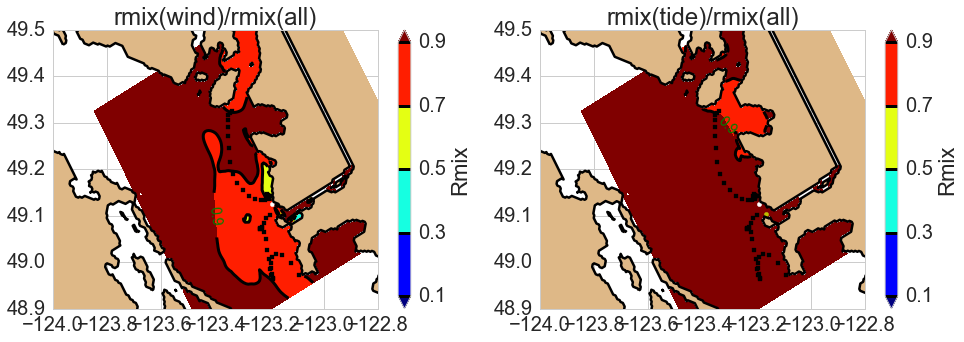

In [39]:
## the whole domain, weak winds + neap tides
threshold_whole_domain(river_T,nowind_T,notide_T,nof_T,all_T,48,143,4,lon_par,lat_par,strings = strings)

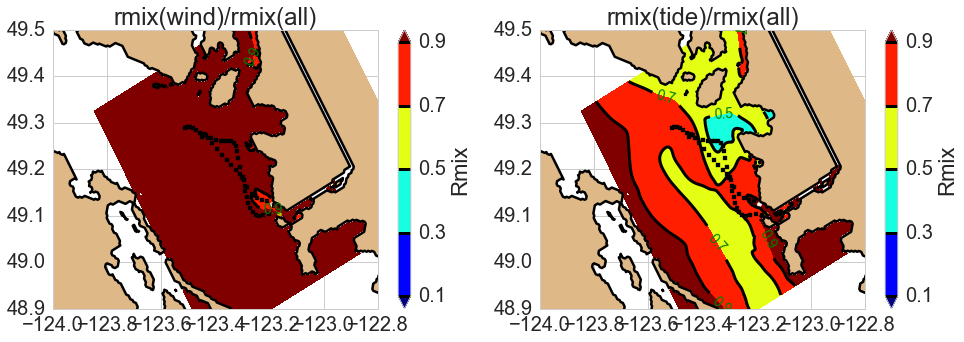

In [40]:
## the whole domain, moderate winds + neap tides
threshold_whole_domain(river_T,nowind_T,notide_T,nof_T,all_T,408,479,4,lon_par,lat_par,strings = strings)

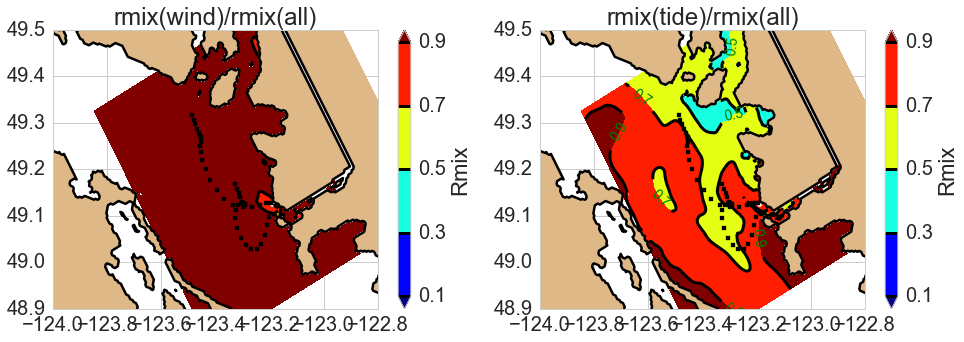

In [41]:
## the whole domain, strong winds + neap tides
threshold_whole_domain(river_T,nowind_T,notide_T,nof_T,all_T,480,551,4,lon_par,lat_par,strings = strings)

* By employing Froude number to define near and far field.

* According to Hetland 2005, $Fr = \frac{u}{\sqrt{g^{'}h}}$, where $u=\int_{-h}^{\eta}\abs{u} dz$ is the depth-dependent flow speed,
$g^{'} = g \frac{\Delta\rho}{\rho_{0}}$, $\Delta\rho = \rho_{0} - \frac{\int_{-h}^{\eta}\rho\abs{u}dz}{\int_{-h}^{\eta}\abs{u}dz}$

In [10]:
def calculate_density(t, s):
    """Caluclates the density given temperature in deg C (t)
    and salinity in psu (s).

    returns the density as an array (rho)
    """
    rho = (
        999.842594 + 6.793952e-2 * t
        - 9.095290e-3 * t*t + 1.001685e-4 * t*t*t
        - 1.120083e-6 * t*t*t*t + 6.536332e-9 * t*t*t*t*t
        + 8.24493e-1 * s - 4.0899e-3 * t*s
        + 7.6438e-5 * t*t*s - 8.2467e-7 * t*t*t*s
        + 5.3875e-9 * t*t*t*t*s - 5.72466e-3 * s**1.5
        + 1.0227e-4 * t*s**1.5 - 1.6546e-6 * t*t*s**1.5
        + 4.8314e-4 * s*s)
    return rho

In [11]:
def calculate_reducedGravity(t,s,to_speed,to_speed_inte,tst,ted,ssh,dep_ind):
    """Calculate g', which is g*deltaRho/Rho0 = g(1-integral(rouUdz/Udz)/Rho0)
    Here Rho0 = 1035, g= 9.80665"""
    rho = calculate_density(t,s)
    # acceleration due to gravity
    g = 9.80665
    rho0=1035 #NEMO fvalue in kg/m^3
    change = np.zeros(to_speed.shape)
    for t in np.arange(ted+1-tst):
        for z in np.arange(dep_ind):
            adj_ssh = 1+ssh[t+tst]/np.sum(e3t[:]*tmask[:],axis = 0)
            change[t,z] = rho[t,z,1:,1:]*to_speed[t,z]*e3t[z,1:,1:]*adj_ssh[1:,1:]
    change = np.nansum(change,axis = 1)
    g_prime = g*(1-change/(rho0*to_speed_inte))

    return g_prime

In [12]:
def Fr_No(grid_T1,grid_T2,grid_T3,grid_T4,grid_T5,grid_U1,grid_U2,grid_U3,grid_U4,grid_U5,\
         grid_V1,grid_V2,grid_V3,grid_V4,grid_V5,tst,ted,dep_ind):
    """This function was made to calculate the Froude number 
    defined above """
    u = {};v = {};to_speed = {}; to_speed_inte = {};ssh = {};T={};S={};g_prime = {};Fr = {};
    gridTs = [grid_T1,grid_T2,grid_T3,grid_T4,grid_T5]
    gridUs = [grid_U1,grid_U2,grid_U3,grid_U4,grid_U5]
    gridVs = [grid_V1,grid_V2,grid_V3,grid_V4,grid_V5]
    for grid_U,grid_V,grid_T,ti in zip(gridUs,gridVs,gridTs,['onlyriver','nowind','notide','nof','all']):
        u[ti] = grid_U.variables['vozocrtx']
        v[ti] = grid_V.variables['vomecrty']
        u[ti],v[ti] = viz_tools.unstagger(u[ti][tst:ted+1,0:dep_ind],\
                                          v[ti][tst:ted+1,0:dep_ind])
        to_speed[ti] = np.sqrt(u[ti]**2+v[ti]**2)
        to_speed_inte[ti] = np.zeros(to_speed[ti].shape)
        ssh[ti] = grid_T.variables['sossheig']
        T[ti] = grid_T.variables['votemper'][tst:ted+1] ## to calculate rho
        S[ti] = grid_T.variables['vosaline'][tst:ted+1]
        dep = grid_T.variables['deptht']
        for t in np.arange(ted+1-tst):
            for z in np.arange(dep_ind):
                adj_ssh = 1+ssh[ti][t+tst]/np.sum(e3t[:]*tmask[:],axis = 0)
                #print(adj_ssh.shape)
                to_speed_inte[ti][t,z] = to_speed[ti][t,z]*e3t[z,1:,1:]*adj_ssh[1:,1:]
    for ti in ['onlyriver','nowind','notide','nof','all']:
        to_speed_inte[ti] = np.nansum(to_speed_inte[ti],axis = 1)
        g_prime[ti] = calculate_reducedGravity(T[ti],S[ti],to_speed[ti],to_speed_inte[ti],tst,ted,ssh[ti],dep_ind)
        Fr[ti] = to_speed_inte[ti]/np.sqrt(g_prime[ti]*dep[dep_ind]) ##Fr 
    return Fr

In [42]:
Fr_1st = Fr_No(river_T,nowind_T,notide_T,nof_T,all_T,river_U,nowind_U,notide_U,nof_U,all_U,\
                              river_V,nowind_V,notide_V,nof_V,all_V,48,143,4)

In [13]:
Fr_2nd = Fr_No(river_T,nowind_T,notide_T,nof_T,all_T,river_U,nowind_U,notide_U,nof_U,all_U,\
                              river_V,nowind_V,notide_V,nof_V,all_V,408,479,4)

In [40]:
Fr_3rd = Fr_No(river_T,nowind_T,notide_T,nof_T,all_T,river_U,nowind_U,notide_U,nof_U,all_U,\
                              river_V,nowind_V,notide_V,nof_V,all_V,480,551,4)

In [45]:
def plot_Fr_eachcase(Fr):
    """This function was made to plot the time averaged 
    Froude number for each run case."""
    fig = plt.figure(figsize=(18,14))
    gs = gridspec.GridSpec(3, 2,width_ratios=[1,1], height_ratios=[1,1,1])  
    gs.update(hspace=0.2, wspace=0.1)
    levels = [0,0.5,1,1.5,2]
    for ti, ax in zip(['onlyriver','nowind','notide','nof','all'],[fig.add_subplot(gs[0,0]),fig.add_subplot(gs[0,1]),\
                     fig.add_subplot(gs[1,0]),fig.add_subplot(gs[1,1]),fig.add_subplot(gs[2,0])]):
        CS = ax.contourf(lon[1:,1:],lat[1:,1:],np.nanmean(Fr[ti],axis = 0),levels,cmap = 'jet',extend='both')
        CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
        cbar = fig.colorbar(CS,ax = ax)
        cbar.add_lines(CS2)
        cbar.set_label('Froude number')
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_title(ti)
        ax.set_xlim([-124.,-122.8])
        ax.set_ylim([48.9,49.5])

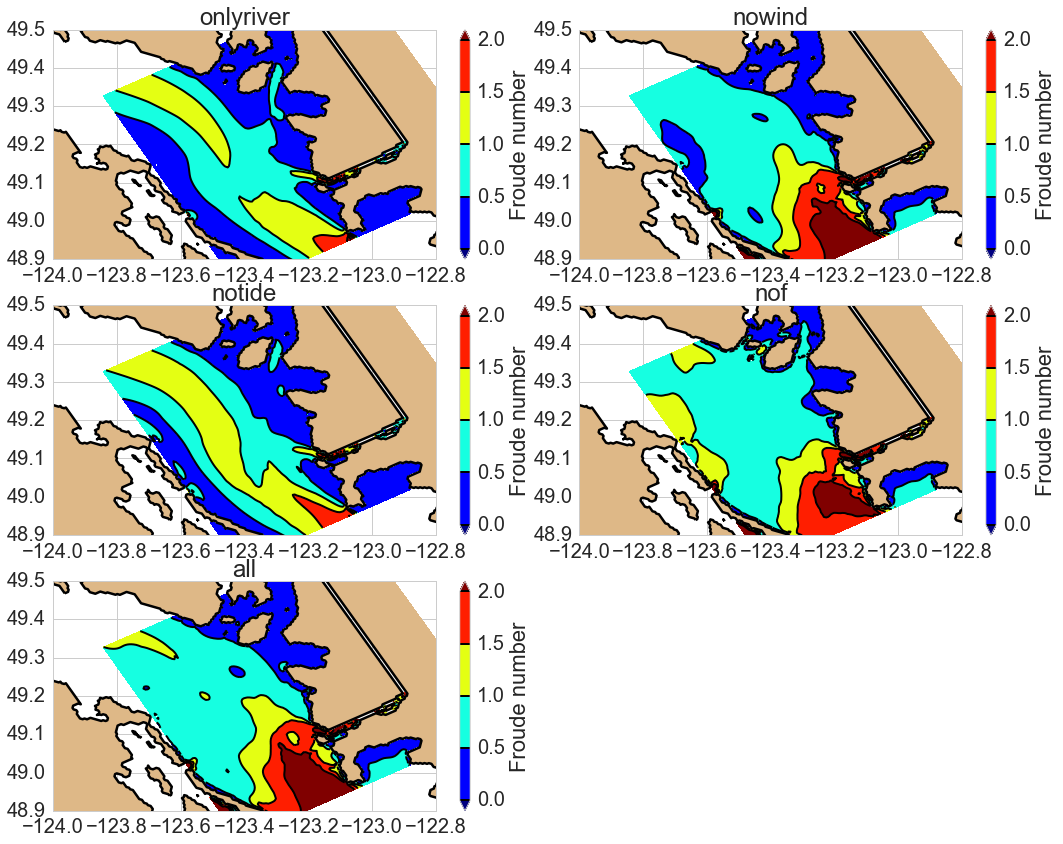

In [46]:
plot_Fr_eachcase(Fr_1st)

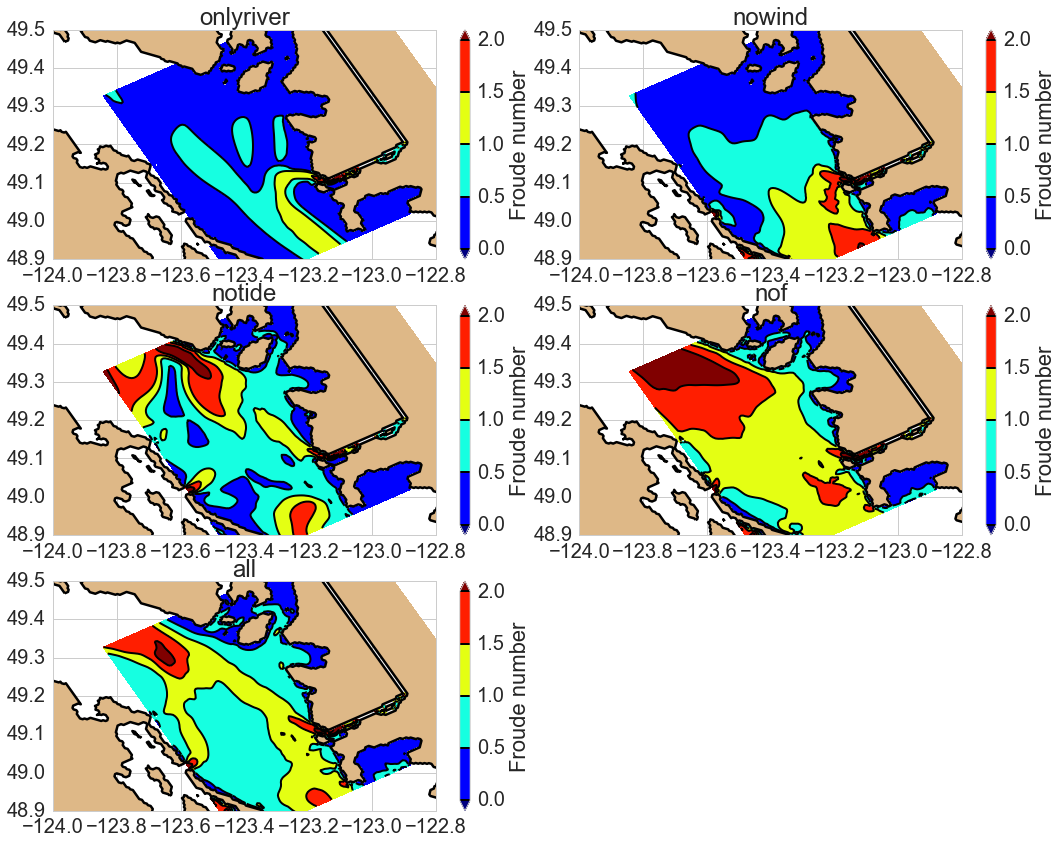

In [47]:
plot_Fr_eachcase(Fr_2nd)

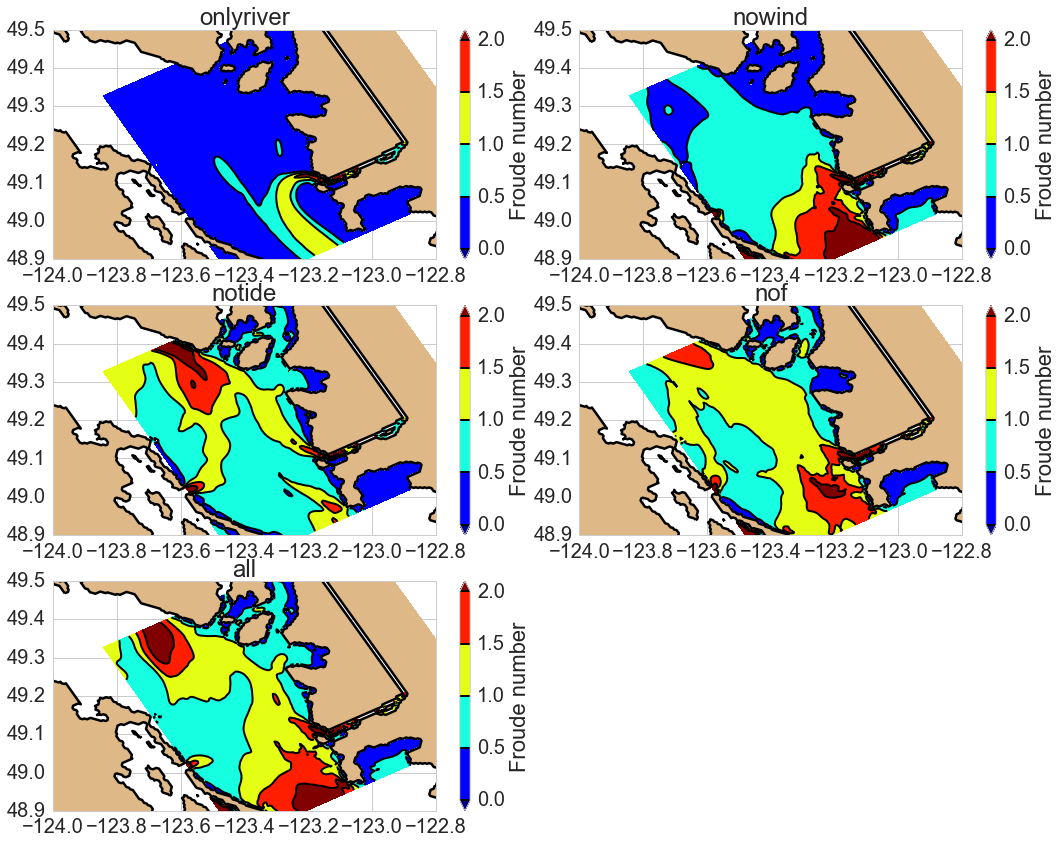

In [48]:
plot_Fr_eachcase(Fr_3rd)

* Overall, if not consider the edge of far-field, near-field region is larger estimated by Froude number by Rmix, suggesting my Rmix criteria not reasonable? Maybe Rmix(tide)/Rmix(all)<= 0.7 is too high for far-field, should down to 0.5 or so?
* In the no rotation case, near-field extends further offshore compared with rotational case, indicating rotation inhibits the spreading near field before it is mixed to far-field, consistent with Cole and Hetland(2015).

* Rmix and Fr at instantaneous time